<a href="https://colab.research.google.com/github/MuhammadIrzam447/MultiModel/blob/master/Valid_38.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!gdown https://drive.google.com/uc?id=1F0-cWEZb32grArL7vBzqLwf_l_yF1EkT

Downloading...
From: https://drive.google.com/uc?id=1F0-cWEZb32grArL7vBzqLwf_l_yF1EkT
To: /content/test.zip
100% 2.21G/2.21G [00:34<00:00, 63.6MB/s]


In [4]:
!gdown https://drive.google.com/uc?id=1pdQLXnI3eykHzTITaDIRNyroPs25aSUS

Downloading...
From: https://drive.google.com/uc?id=1pdQLXnI3eykHzTITaDIRNyroPs25aSUS
To: /content/fused+joint_model.pth
100% 171M/171M [00:03<00:00, 53.6MB/s]


In [5]:
!unzip /content/test.zip

Streaming output truncated to the last 5000 lines.
  inflating: test/fish_and_chips/fish_and_chips_730.jpg.png  
  inflating: test/fish_and_chips/fish_and_chips_699.jpg.png  
  inflating: test/fish_and_chips/fish_and_chips_21.jpg.png  
  inflating: test/fish_and_chips/fish_and_chips_653.jpg.png  
  inflating: test/fish_and_chips/fish_and_chips_914.jpg.png  
  inflating: test/fish_and_chips/fish_and_chips_12.jpg.png  
  inflating: test/fish_and_chips/fish_and_chips_135.jpg.png  
  inflating: test/fish_and_chips/fish_and_chips_810.jpg.png  
  inflating: test/fish_and_chips/fish_and_chips_123.jpg.png  
  inflating: test/fish_and_chips/fish_and_chips_453.jpg.png  
  inflating: test/fish_and_chips/fish_and_chips_446.jpg.png  
  inflating: test/fish_and_chips/fish_and_chips_428.jpg.png  
  inflating: test/fish_and_chips/fish_and_chips_72.jpg.png  
  inflating: test/fish_and_chips/fish_and_chips_637.jpg.png  
  inflating: test/fish_and_chips/fish_and_chips_833.jpg.png  
  inflating: test/fish

In [6]:
from google.colab import drive
import pandas as pd
import os
from PIL import Image
import torch
from torchvision import datasets, transforms
import torchvision.models as models
from torchvision.datasets import ImageFolder
import torchvision
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import UnidentifiedImageError
from sklearn.metrics import classification_report

In [7]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

cuda


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# Loading Validation Dataset and Preprocessing

In [8]:
save_dir = '/content/'
load_path = os.path.join(save_dir, 'fused+joint_model.pth')

# Create an instance of the ResNet model
resnet = torchvision.models.resnet101(pretrained=False)
resnet.fc = nn.Linear(2048, 101) # Choose the number of output classses as per your model

# Load the saved model parameters
resnet.load_state_dict(torch.load(load_path))
# resnet.load_state_dict(torch.load(load_path, map_location=torch.device('cpu')))

# Set the model to evaluation mode and respective device
resnet.eval()
resnet.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [9]:
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [10]:
class ValidationDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.dataset = datasets.ImageFolder(data_dir, transform=val_transform)
        self.classes = sorted(os.listdir(data_dir))
        self.class_lengths = self._compute_class_lengths()

    def _compute_class_lengths(self):
        class_lengths = {cls: 0 for cls in self.classes}

        for cls in self.classes:
            cls_dir = os.path.join(self.data_dir, cls)
            if os.path.isdir(cls_dir):
                class_lengths[cls] = len(os.listdir(cls_dir))

        return class_lengths

    def __getitem__(self, index):
        image, label = self.dataset[index]
        return image, label

    def __len__(self):
        return len(self.dataset)

In [11]:
valPath = "/content/test"
val_dataset = ValidationDataset(valPath)

In [12]:
batch_size = 32
validation_data_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [13]:
print("Number of samples:", len(val_dataset))
print("Number of classes:", len(val_dataset.classes))

Number of samples: 22716
Number of classes: 101


In [14]:
num_batches = len(validation_data_loader)
print("Number of batches:", num_batches)

Number of batches: 710


# Validation

In [15]:
resnet.eval()

predicted_classes = []
actual_labels = []

with torch.no_grad():
    for images, labels in validation_data_loader:
        # Move the images and labels to the GPU if available
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = resnet(images)

        # Get the predicted labels
        _, predicted_label = torch.max(outputs, 1)

        # Store the predicted and true labels
        predicted_classes.extend(predicted_label.cpu().tolist())
        actual_labels.extend(labels.cpu().tolist())

In [16]:
accuracy = accuracy_score(actual_labels, predicted_classes)
precision = precision_score(actual_labels, predicted_classes, average='weighted')
recall = recall_score(actual_labels, predicted_classes, average='weighted')
f1 = f1_score(actual_labels, predicted_classes, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.9097992604331748
Precision: 0.9099252252513411
Recall: 0.9097992604331748
F1-score: 0.9092049512018134


In [17]:
print(classification_report(actual_labels, predicted_classes))

              precision    recall  f1-score   support

           0       0.92      0.94      0.93       234
           1       0.93      0.95      0.94       221
           2       0.96      0.96      0.96       226
           3       0.81      0.87      0.84       222
           4       0.78      0.67      0.72       225
           5       0.88      0.95      0.91       224
           6       0.92      0.93      0.92       224
           7       0.91      0.91      0.91       225
           8       0.91      0.98      0.94       226
           9       0.89      0.88      0.88       214
          10       0.93      0.95      0.94       231
          11       0.93      0.95      0.94       227
          12       0.91      0.95      0.93       230
          13       0.94      0.95      0.95       220
          14       0.96      0.88      0.92       231
          15       0.92      0.95      0.93       227
          16       0.75      0.80      0.78       224
          17       0.93    

In [18]:
predicted_classes = np.array(predicted_classes)
actual_labels = np.array(actual_labels)

In [19]:
accuracy = accuracy_score(actual_labels, predicted_classes)
precision = precision_score(actual_labels, predicted_classes, average='weighted')
recall = recall_score(actual_labels, predicted_classes, average='weighted')
f1 = f1_score(actual_labels, predicted_classes, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.9097992604331748
Precision: 0.9099252252513411
Recall: 0.9097992604331748
F1-score: 0.9092049512018134


In [20]:
print(classification_report(actual_labels, predicted_classes))

              precision    recall  f1-score   support

           0       0.92      0.94      0.93       234
           1       0.93      0.95      0.94       221
           2       0.96      0.96      0.96       226
           3       0.81      0.87      0.84       222
           4       0.78      0.67      0.72       225
           5       0.88      0.95      0.91       224
           6       0.92      0.93      0.92       224
           7       0.91      0.91      0.91       225
           8       0.91      0.98      0.94       226
           9       0.89      0.88      0.88       214
          10       0.93      0.95      0.94       231
          11       0.93      0.95      0.94       227
          12       0.91      0.95      0.93       230
          13       0.94      0.95      0.95       220
          14       0.96      0.88      0.92       231
          15       0.92      0.95      0.93       227
          16       0.75      0.80      0.78       224
          17       0.93    

In [21]:
# from sklearn.metrics import roc_auc_score

# # Convert the predicted_classes and actual_labels lists to numpy arrays
# predicted_classes = np.array(predicted_classes)
# actual_labels = np.array(actual_labels)

# # Calculate the AUROC score
# auroc = roc_auc_score(actual_labels, predicted_classes)

# print("AUROC:", auroc)

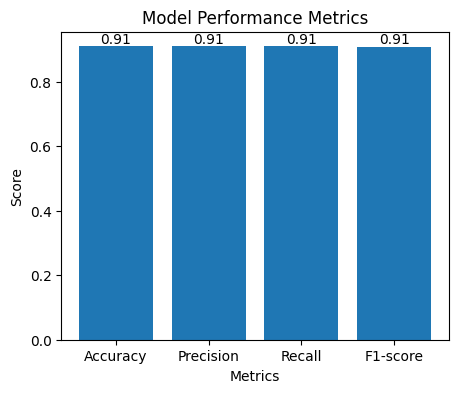

In [22]:
labels = ['Accuracy', 'Precision', 'Recall', 'F1-score']
values = [accuracy, precision, recall, f1]

x = np.arange(len(labels))

fig, ax = plt.subplots(figsize=(5, 4))
bars = ax.bar(x, values)

# labels, title, and legend
ax.set_xlabel('Metrics')
ax.set_ylabel('Score')
ax.set_title('Model Performance Metrics')
ax.set_xticks(x)
ax.set_xticklabels(labels)

# scores on top of each bar
for i, bar in enumerate(bars):
    score = values[i]
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{score:.2f}', ha='center', va='bottom')

plt.show()

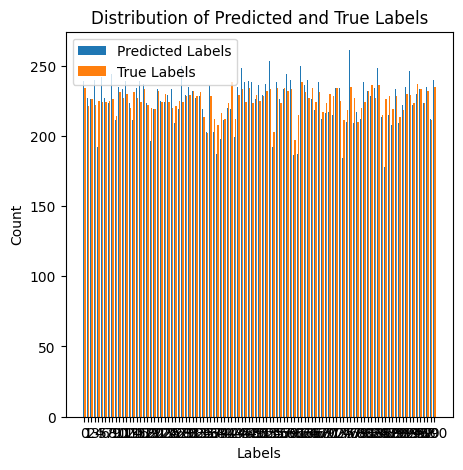

In [23]:
# Count the occurrences of each label in predicted and true labels
predicted_counts = np.bincount(predicted_classes)
true_counts = np.bincount(actual_labels)

# Get the unique labels
labels = np.unique(np.concatenate((predicted_classes, actual_labels)))

# Set the x-axis range
x = np.arange(len(labels))

# Set the width of the bars
width = 0.35

# Plot the predicted and true label counts
fig, ax = plt.subplots(figsize=(5,5))
ax.bar(x - width/2, predicted_counts, width, label='Predicted Labels')
ax.bar(x + width/2, true_counts, width, label='True Labels')

# Add labels, title, and legend
ax.set_xlabel('Labels')
ax.set_ylabel('Count')
ax.set_title('Distribution of Predicted and True Labels')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()